# Constants

In [2]:
ROOT_PATH = "/kaggle/input"
DATA_PATH = "/kaggle/input/monusac-pannuke-consep"

In [3]:
DATASET = "MoNuSAC" # MoNuSAC, PanNuke, CoNSeP_Tiled
NUM_CLASSES = 5 # 5, 6, 8
BATCH_SIZE = 32

# Data Loading

In [4]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Root dataset directory, e.g., "MoNuSAC"
            split (str): One of 'train', 'val', 'test'
            image_transform (callable, optional): Transform applied only to image
        """
        self.split_dir = os.path.join(root_dir, split)
        self.sample_dirs = sorted([
            os.path.join(self.split_dir, d)
            for d in os.listdir(self.split_dir)
            if os.path.isdir(os.path.join(self.split_dir, d))
        ])
        self.transform = transform

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]

        image = np.load(os.path.join(sample_dir, "image.npy"))  # HWC
        mask = np.load(os.path.join(sample_dir, "mask.npy"))    # HW
        h_map = np.load(os.path.join(sample_dir, "h_map.npy"))  # HW
        v_map = np.load(os.path.join(sample_dir, "v_map.npy"))  # HW

        h_map = (h_map.astype(np.float32) / 127.5) - 1.0
        v_map = (v_map.astype(np.float32) / 127.5) - 1.0

        if self.transform:
            image = self.transform(image)

        return image, \
                torch.from_numpy(mask).long(), \
                torch.from_numpy(h_map).float(), \
                torch.from_numpy(v_map).float()

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts HWC to CHW and scales to [0, 1]
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # example: scale to [-1, 1]
])

dataset_path = os.path.join(DATA_PATH, DATASET)

train_dataset = SegmentationDataset(dataset_path, split="train", transform=transform)
val_dataset = SegmentationDataset(dataset_path, split="val", transform=transform)
test_dataset = SegmentationDataset(dataset_path, split="test", transform=transform)

In [6]:
from torch.utils.data import Dataset, DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
print("First fold:", len(train_dataloader))
print("Second fold:", len(val_dataloader))
print("Third fold:", len(test_dataloader))

First fold: 6
Second fold: 1
Third fold: 4


In [8]:
image, mask, h_map, v_map = next(iter(train_dataloader))
print(image.shape)
print(mask.shape)
print(h_map.shape)
print(v_map.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 256, 256])
torch.Size([32, 256, 256])
torch.Size([32, 256, 256])


# Graph HoVerNet

In [9]:
!pip install -U segmentation-models-pytorch torch-geometric scikit-image

In [10]:
def get_sinusoidal_encoding(coords, num_freqs=64):
    """
    coords: (N, 2) integer tensor with (y, x) positions
    returns: (N, 4 * num_freqs) tensor of sinusoidal embeddings
    """
    device = coords.device
    N = coords.size(0)
    freqs = torch.arange(num_freqs, dtype=torch.float32, device=device)  # [0, 1, ..., num_freqs-1]
    freqs = 1.0 / (10000 ** (freqs / num_freqs))  # shape: [num_freqs]

    pos_y = coords[:, 0].unsqueeze(1).float()  # [N, 1]
    pos_x = coords[:, 1].unsqueeze(1).float()  # [N, 1]

    y_embed = pos_y * freqs  # [N, num_freqs]
    x_embed = pos_x * freqs

    sin_cos_y = torch.cat([y_embed.sin(), y_embed.cos()], dim=1)
    sin_cos_x = torch.cat([x_embed.sin(), x_embed.cos()], dim=1)
    return torch.cat([sin_cos_y, sin_cos_x], dim=1)  # [N, 4 * num_freqs]

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data, Batch
from sklearn.neighbors import NearestNeighbors
import numpy as np

from torch_geometric.nn import GENConv, LayerNorm, Linear


class GraphBranch(nn.Module):
    """Node-level GNN classifier using 3-layer GENConv with edge_attr"""
    def __init__(self, in_channels=512, hidden_channels=128, edge_dim=256, num_layers=3, num_classes=5, dropout=0.1):
        super().__init__()

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        self.convs.append(GENConv(in_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        for _ in range(num_layers - 2):
            self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
            self.norms.append(LayerNorm(hidden_channels))

        self.convs.append(GENConv(hidden_channels, hidden_channels, edge_dim=edge_dim))
        self.norms.append(LayerNorm(hidden_channels))

        self.classifier = nn.Sequential(
            Linear(hidden_channels, hidden_channels // 2),
            LayerNorm(hidden_channels // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            Linear(hidden_channels // 2, num_classes)
        )

        self.dropout = dropout

    def forward(self, x, edge_index, edge_attr):
        x = self.convs[0](x, edge_index, edge_attr)
        x = self.norms[0](x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for i in range(1, len(self.convs) - 1):
            residual = x
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.norms[i](x)
            x = F.relu(x + residual)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.convs[-1](x, edge_index, edge_attr)
        x = self.norms[-1](x)
        x = F.relu(x)

        node_pred = self.classifier(x)
        return node_pred, x  # logits, final embeddings

class GraphHoverNet(nn.Module):
    def __init__(self, num_classes=6, encoder_name='resnet34', encoder_weights='imagenet', 
                 use_graph=True, k_neighbors=8, graph_feature_dim=288):
        super().__init__()
        self.use_graph = use_graph
        self.k_neighbors = k_neighbors

        # Shared encoder
        self.shared_encoder = smp.encoders.get_encoder(encoder_name, in_channels=3, depth=5, weights=encoder_weights)

        # Use shared encoder in all heads
        self.model_np = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_hv = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=2, activation=None)
        self.model_nc = smp.Unet(encoder_name=encoder_name, encoder_weights=None,
                                         in_channels=3, classes=num_classes, activation=None)

        self.model_np.encoder = self.shared_encoder
        self.model_hv.encoder = self.shared_encoder
        self.model_nc.encoder = self.shared_encoder

        if self.use_graph:
            self.graph_branch = GraphBranch(in_channels=graph_feature_dim,
                                            num_layers=2, num_classes=num_classes)

    def set_stage(self, stage):
        if stage == 'pretrain':
            self.use_graph = False

            for m in [self.model_np, self.model_hv, self.model_nc]:
                    for p in m.parameters():
                        p.requires_grad = True

        elif stage == 'finetune':
            self.use_graph = True

            for p in self.shared_encoder.parameters():
                p.requires_grad = False

            # Unfreeze everything else
            for m in [self.model_np.decoder, self.model_np.segmentation_head,
                      self.model_hv.decoder, self.model_hv.segmentation_head,
                      self.model_nc.decoder, self.model_nc.segmentation_head,
                      self.graph_branch]:
                for p in m.parameters():
                    p.requires_grad = True
                    
    def extract_nucleus_centroids(self, np_pred, hv_pred, threshold=0.5):
        batch_size = np_pred.shape[0]
        centroids_list = []
        for b in range(batch_size):
            prob_map = torch.sigmoid(np_pred[b, 1])
            mask = prob_map > threshold
            if mask.sum() == 0:
                centroids_list.append(torch.empty(0, 2).to(np_pred.device))
                continue
            coords = torch.nonzero(mask, as_tuple=False).float()
            if coords.shape[0] > 500:
                probs = prob_map[mask]
                _, top_indices = torch.topk(probs, 500)
                coords = coords[top_indices]
            centroids_list.append(coords)
        return centroids_list

    def build_graph(self, centroids, features):
        if centroids.shape[0] == 0:
            return torch.empty(2, 0).long().to(centroids.device)
        centroids_np = centroids.cpu().numpy()
        if centroids_np.shape[0] <= self.k_neighbors:
            n = centroids_np.shape[0]
            edges = []
            for i in range(n):
                for j in range(i + 1, n):
                    edges.extend([[i, j], [j, i]])
            if len(edges) == 0:
                return torch.empty(2, 0).long().to(centroids.device)
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        else:
            nbrs = NearestNeighbors(n_neighbors=min(self.k_neighbors + 1, centroids_np.shape[0]))
            nbrs.fit(centroids_np)
            distances, indices = nbrs.kneighbors(centroids_np)
            edges = []
            for i in range(indices.shape[0]):
                for j in range(1, indices.shape[1]):
                    edges.extend([[i, indices[i, j]], [indices[i, j], i]])
            edge_index = torch.tensor(edges).t().contiguous().to(centroids.device)
        return edge_index

    def forward(self, x):
        batch_size = x.shape[0]
        out_np = self.model_np(x)
        out_hv = self.model_hv(x)
        out_nc = self.model_nc(x)
        if not self.use_graph:
            return out_np, out_hv, out_nc, None, None

        out_gc = None
        graph_enhanced_nc = out_nc.clone()
        encoder_feats = self.shared_encoder(x)
        encoder_features = F.interpolate(encoder_feats[-2], size=(255, 255), mode="bilinear", align_corners=False)

        all_centroids = []
        all_out_gc = []
        
        for b in range(batch_size):
            centroids = self.extract_nucleus_centroids(out_np[b:b+1], out_hv[b:b+1], threshold=0.3)[0]
            if centroids.shape[0] == 0:
                continue
            h, w = encoder_features.shape[2], encoder_features.shape[3]
            centroid_coords = centroids.long()
            centroid_coords[:, 0] = torch.clamp(centroid_coords[:, 0], 0, h - 1)
            centroid_coords[:, 1] = torch.clamp(centroid_coords[:, 1], 0, w - 1)
            node_feats = encoder_features[b, :, centroid_coords[:, 0], centroid_coords[:, 1]].t()
            
            # Generate sinusoidal positional encodings
            pos_enc = get_sinusoidal_encoding(centroid_coords, num_freqs=8)  # [N, 32]
            
            # Concatenate encoder + positional features
            node_features = torch.cat([node_feats, pos_enc], dim=1)  # [N, C + 32]

            edge_index = self.build_graph(centroids, node_features)

            mid = ((centroid_coords[edge_index[0]] + centroid_coords[edge_index[1]]) / 2).long()
            mid[:, 0] = mid[:, 0].clamp(0, 254)
            mid[:, 1] = mid[:, 1].clamp(0, 254)
            
            # Edge attributes from midpoints
            edge_attr = encoder_features[b][:, mid[:, 0], mid[:, 1]].t()  # [num_edges, C]
            if edge_index.shape[1] > 0:
                out_gc, _ = self.graph_branch(node_features, edge_index, edge_attr)
                all_centroids.append(torch.cat([centroid_coords, torch.full((centroid_coords.shape[0], 1), b, device=x.device)], dim=1))  # (N, 3): (y, x, batch_id)
                all_out_gc.append(out_gc)

        if all_centroids:
            centroid_coords = torch.cat(all_centroids, dim=0)  # (sum(N), 3)
            out_gc = torch.cat(all_out_gc, dim=0)              # (sum(N), C)
        else:
            centroid_coords = torch.empty(0, 3, device=x.device)
            out_gc = None

        return out_np, out_hv, out_nc, centroid_coords, out_gc

    def print_model_stats(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    
        def count_params(module):
            return sum(p.numel() for p in module.parameters())
    
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Shared encoder parameters: {count_params(self.shared_encoder):,}")
        print(f"NP head parameters (excluding encoder): {count_params(self.model_np.decoder) + count_params(self.model_np.segmentation_head):,}")
        print(f"HV head parameters (excluding encoder): {count_params(self.model_hv.decoder) + count_params(self.model_hv.segmentation_head):,}")
        print(f"NC head parameters (excluding encoder): {count_params(self.model_nc.decoder) + count_params(self.model_nc.segmentation_head):,}")
        print(f"Graph branch parameters: {count_params(self.graph_branch):,}")

In [21]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class DiceCoeff(nn.Module):
    def __init__(self, ignore_index: int = None, smooth: float = 1e-7):
        super().__init__()
        self.ignore_index = ignore_index
        self.smooth = smooth

    def forward(self, inputs, targets):
        """
        inputs: (N, C, ...) — raw logits
        targets: (N, ...) — class indices
        """
        inputs = F.softmax(inputs, dim=1)  # Convert to probabilities
        N, C = inputs.shape[:2]
        spatial_dims = inputs.shape[2:]  # Arbitrary spatial shape

        # One-hot encode targets to (N, C, ...)
        targets_onehot = F.one_hot(targets, num_classes=C).permute(0, -1, *range(1, targets.ndim)).float()

        # Flatten all dimensions except batch and channel
        inputs_flat = inputs.view(N, C, -1)
        targets_flat = targets_onehot.view(N, C, -1)

        # Optional: handle ignore index
        if self.ignore_index is not None:
            mask = targets != self.ignore_index  # shape (N, ...)
            mask = mask.view(N, -1).unsqueeze(1)  # (N, 1, num_voxels)
            inputs_flat = inputs_flat * mask
            targets_flat = targets_flat * mask

        intersection = (inputs_flat * targets_flat).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (
            inputs_flat.sum(dim=2) + targets_flat.sum(dim=2) + self.smooth
        )
        return 1 - dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', ignore_index=-100):
        """
        Multi-class focal loss implementation.
        Args:
            alpha (float): balancing factor for classes.
            gamma (float): focusing parameter.
            reduction (str): 'mean', 'sum' or 'none'.
            ignore_index (int, optional): class index to ignore in loss.
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none', ignore_index=self.ignore_index)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
            
class LaplacianLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a 3x3 Laplacian kernel
        kernel = torch.tensor([[0, 1, 0],
                               [1, -4, 1],
                               [0, 1, 0]], dtype=torch.float32).view(1, 1, 3, 3)
        self.register_buffer('kernel', kernel)

    def forward(self, pred: torch.Tensor):
        """
        Args:
            pred: (N, 1, H, W) tensor on any device
        Returns:
            Laplacian smoothness loss (scalar)
        """
        # Move kernel to the same device as pred
        if pred.dim() == 3:
            pred = pred.unsqueeze(1)
        kernel = self.kernel.to(pred.device)
        pred_lap = F.conv2d(pred, kernel, padding=1)
        return torch.mean(torch.abs(pred_lap))

class _NPBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super(_NPBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.alpha = alpha
        self.beta = beta

    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss


class _HVBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1):
        super().__init__()
        self.laplacian = LaplacianLoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, logits: torch.Tensor, h_grads: torch.Tensor, v_grads: torch.Tensor):
        hl = logits[:, 0, :, :]
        vl = logits[:, 1, :, :]

        mse_loss = F.mse_loss(hl, h_grads) + F.mse_loss(vl, v_grads)
        laplacian_loss = self.laplacian(hl) + self.laplacian(vl)

        return self.alpha * mse_loss + self.beta * laplacian_loss

class _GCBranchLoss(nn.Module):
    def __init__(self, alpha=1, beta=1, gamma=1):
        super(_GCBranchLoss, self).__init__()
        self.dice_coeff = DiceCoeff()
        self.focal_loss = FocalLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, targets)
        dice_loss = 1 - self.dice_coeff(logits, targets)
        focal_loss = self.focal_loss(logits, targets)
        return self.alpha * ce_loss + self.beta * dice_loss + self.gamma * focal_loss
        
class HoverLoss(nn.Module):
    def __init__(self):
        super(HoverLoss, self).__init__()
        self.np_loss = _NPBranchLoss(0.75, 0.25)
        self.hv_loss = _HVBranchLoss(0.5, 0.5)
        self.nc_loss = _NPBranchLoss(0.75, 0.25)
        self.gc_loss = _GCBranchLoss(1, 1, 1)

    def forward(self, np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                gc_logits=None, gc_targets=None,
                weights=(1, 1, 1, 1)) -> torch.Tensor:

        loss_np = self.np_loss(np_logits, np_targets) * weights[0]
        loss_hv = self.hv_loss(hv_logits, h_grads, v_grads) * weights[1]
        loss_nc = self.nc_loss(nc_logits, nc_targets) * weights[2]

        if gc_logits is not None and gc_targets is not None and gc_logits.numel() > 0:
            loss_gc = self.gc_loss(gc_logits, gc_targets) * weights[3]
        else:
            loss_gc = torch.tensor(0.0, device=np_logits.device)

        return loss_np + loss_hv + loss_nc + loss_gc

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphHoverNet(num_classes=NUM_CLASSES)
model = model.to(device)
criterion = HoverLoss()

In [72]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [59]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

def postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device, return_centroids=False, nr_types=6):
    """
    Postprocess HoVerNet outputs to obtain instance segmentation and class predictions.

    Args:
        np_logits (Tensor): [B, 1, H, W] - nuclei presence logits.
        hv_logits (Tensor): [B, 2, H, W] - horizontal and vertical offset logits.
        nc_logits (Tensor): [B, C, H, W] - nuclear classification logits.
        device (torch.device): Device for output tensors.
        return_centroids (bool): Placeholder for future use.
        nr_types (int): Number of nuclear classes.

    Returns:
        Tensor: [B, H, W] instance segmentation with class IDs.
    """
    def process(pred_map: torch.Tensor) -> torch.Tensor:
        """
        Process a single HoVerNet prediction map to obtain instance-wise segmentation with class labels.

        Args:
            pred_map (Tensor): [H, W, 4] - np_mask, h_map, v_map, class_map

        Returns:
            Tensor: [H, W] with instance-wise majority-vote class labels.
        """
        pred_map = pred_map.cpu().numpy()
        np_mask = pred_map[:, :, 0] > 0.5
        h_map = pred_map[:, :, 1]
        v_map = pred_map[:, :, 2]
        class_map = pred_map[:, :, 3].astype(np.int32)

        # --- Energy landscape: gradient magnitude ---
        dx = cv2.Sobel(h_map, cv2.CV_64F, 1, 0, ksize=3)
        dy = cv2.Sobel(v_map, cv2.CV_64F, 0, 1, ksize=3)
        energy = np.sqrt(dx ** 2 + dy ** 2)

        energy = (energy - energy.min()) / (energy.max() - energy.min() + 1e-8)
        energy = 1.0 - energy  # Nuclei centers become minima

        # --- Marker-based watershed ---
        distance = ndi.distance_transform_edt(np_mask)
        coords = peak_local_max(distance, labels=np_mask, footprint=np.ones((3, 3)), exclude_border=False)
        markers = np.zeros_like(np_mask, dtype=np.int32)
        for idx, (y, x) in enumerate(coords, start=1):
            markers[y, x] = idx

        instance_map = watershed(energy, markers=markers, mask=np_mask)

        # --- Majority vote for class per instance ---
        type_map = np.zeros_like(instance_map, dtype=np.int32)
        for inst_id in range(1, instance_map.max() + 1):
            mask = instance_map == inst_id
            class_ids, counts = np.unique(class_map[mask], return_counts=True)
            if len(class_ids) > 0:
                majority_class = class_ids[np.argmax(counts)]
                type_map[mask] = majority_class

        return torch.from_numpy(type_map).long().to(device)

    # --- Batch processing ---
    batch_size = np_logits.shape[0]
    np_pred = torch.argmax(np_logits, dim=1, keepdim=True)  # [B, 1, H, W]
    nc_pred = torch.argmax(nc_logits, dim=1, keepdim=True)  # [B, 1, H, W]

    results = []
    for i in range(batch_size):
        nuclei_presence = np_pred[i].permute(1, 2, 0)           # [H, W, 1]
        h_map = hv_logits[i, 0:1].permute(1, 2, 0)              # [H, W, 1]
        v_map = hv_logits[i, 1:2].permute(1, 2, 0)              # [H, W, 1]
        class_map = nc_pred[i].permute(1, 2, 0) if nr_types else torch.zeros_like(h_map)

        pred_map = torch.cat([nuclei_presence, h_map, v_map, class_map], dim=-1)  # [H, W, 4]
        instance_seg = process(pred_map)  # [H, W]
        results.append(instance_seg)

    return torch.stack(results)  # [B, H, W]

In [60]:
def get_node_labels_from_coords(centroid_coords, type_maps):
    """
    Args:
        centroid_coords: (N, 3) tensor, (y, x, batch_id)
        type_maps: (B, H, W) tensor of type labels

    Returns:
        labels: (N,) long tensor
    """
    y = centroid_coords[:, 0].clamp(0, type_maps.shape[1] - 1)
    x = centroid_coords[:, 1].clamp(0, type_maps.shape[2] - 1)
    b = centroid_coords[:, 2].clamp(0, type_maps.shape[0] - 1)

    return type_maps[b, y, x]

In [61]:
model.set_stage("pretrain")

with torch.no_grad():
    images, masks, h_grads, v_grads = next(iter(train_dataloader))
    images = images.to(device)
    masks = masks.to(device).long()
    h_grads = h_grads.to(device)
    v_grads = v_grads.to(device)

    nc_targets = masks
    np_targets = (nc_targets > 0).long()

    np_logits, hv_logits, nc_logits, centroids, gc_logits = model(images)

    if gc_logits is not None and centroids.shape[0] > 0:
        node_labels = get_node_labels_from_coords(centroids, nc_targets)
        valid = node_labels != 0
    
        if valid.any():
            graph_loss_inputs = (gc_logits[valid], node_labels[valid])
        else:
            # No valid labels — skip graph loss
            graph_loss_inputs = (None, None)
    else:
        # No graph predictions — skip graph loss
        graph_loss_inputs = (None, None)
    
    loss = criterion(
        np_logits, np_targets,
        hv_logits, h_grads, v_grads,
        nc_logits, nc_targets,
        *graph_loss_inputs
    )
    
    # # Evaluate
    nc_pred = torch.argmax(nc_logits, dim=1)
    # iou = compute_multiclass_iou(pred_inst, nc_targets, num_classes=6)
    # pq = compute_multiclass_pq(pred_inst, nc_targets, num_classes=6)

    # Postprocess
    postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)

    tp, fp, fn, tn = smp.metrics.get_stats(
        postprocessed_pred, nc_targets,
        mode='multiclass',
        num_classes=NUM_CLASSES
    )

    iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)[1:]
    pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)
    
    print("Loss:", loss)
    print("AJI:", iou_per_class.mean())
    print("PQ:", pq_per_class.mean())
    print("Average F1:", f1_per_class.mean())
    print("F1 Per Class:", f1_per_class)

Loss: tensor(4.1305, device='cuda:0')
AJI: tensor(0.0130)
PQ: tensor(0.0168)
Average F1: tensor(0.0237)
F1 Per Class: tensor([0.0283, 0.0013, 0.0067, 0.0588])


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from skimage.color import label2rgb

def visualize_hovernet_output(pred_inst, inst_info=None, show_types=True):
    """
    Visualize the instance segmentation map with optional type labels and centroids.

    Args:
        pred_inst (np.ndarray): [H, W] array of instance IDs.
        inst_info (dict): {inst_id: {'centroid': (x, y), 'type': int}}, optional.
        show_types (bool): If True, display type labels at centroid positions.
    """

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(pred_inst, cmap="jet")
    ax.set_title("Instance Segmentation")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

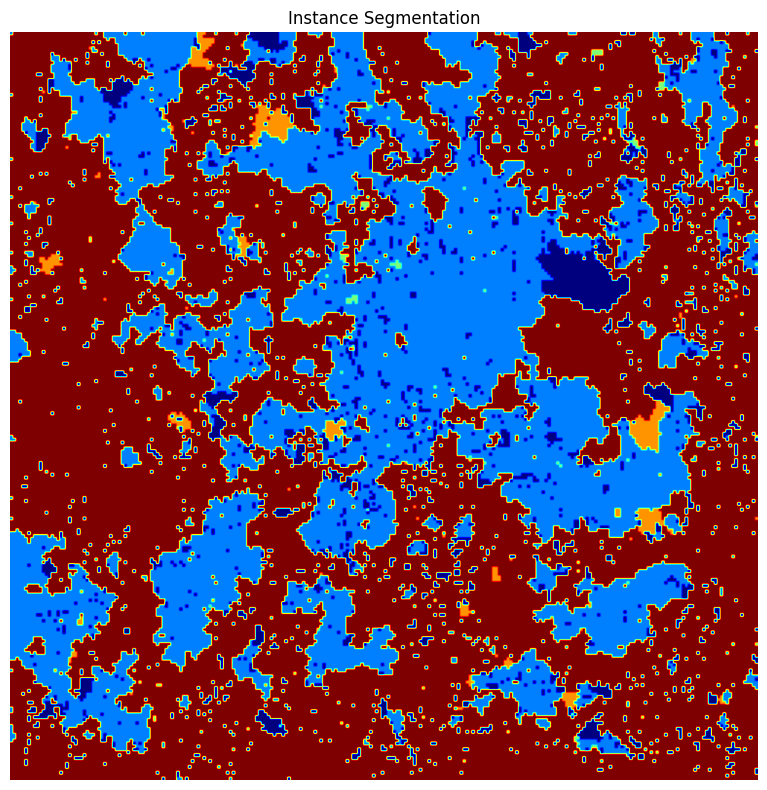

In [63]:
visualize_hovernet_output(postprocessed_pred.cpu().numpy()[0])

In [64]:
from tqdm import tqdm
import torch
from torch.amp import GradScaler, autocast
import segmentation_models_pytorch as smp

def train_one_epoch(model, dataloader, optimizer, criterion, device, num_classes=5):
    model.train()
    scaler = GradScaler()

    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Training", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        optimizer.zero_grad()

        with autocast(device.type):
            np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

            # Get graph branch labels
            if gc_logits is not None and centroids.shape[0] > 0:
                gc_targets = get_node_labels_from_coords(centroids, nc_targets)
                valid = gc_targets != 0
                if valid.any():
                    gc_input = (gc_logits[valid], gc_targets[valid])
                else:
                    gc_input = (None, None)
            else:
                gc_input = (None, None)

            # Compute total loss
            loss = criterion(
                np_logits, np_targets,
                hv_logits, h_grads, v_grads,
                nc_logits, nc_targets,
                *gc_input
            )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            nc_pred = torch.argmax(nc_logits, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(
                nc_pred, nc_targets,
                mode='multiclass',
                num_classes=num_classes  # assuming class 0 is background
            )

            iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
            pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate per class
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [65]:
@torch.no_grad()
def validate(model, dataloader, criterion, device, num_classes=5, post_process=False):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_pq = 0.0
    total_f1_per_class = torch.zeros(num_classes, dtype=torch.float32, device=device)
    count = 0

    loop = tqdm(dataloader, desc="Validation", leave=True)
    for image, mask, h_grads, v_grads in loop:
        image = image.to(device)
        mask = mask.to(device).long()
        h_grads = h_grads.to(device)
        v_grads = v_grads.to(device)

        nc_targets = mask
        np_targets = (mask > 0).long()

        np_logits, hv_logits, nc_logits, centroids, gc_logits = model(image)

        # Process graph branch if available
        if gc_logits is not None and centroids.shape[0] > 0:
            gc_targets = get_node_labels_from_coords(centroids, nc_targets)
            valid = gc_targets != 0
            if valid.any():
                gc_input = (gc_logits[valid], gc_targets[valid])
            else:
                gc_input = (None, None)
        else:
            gc_input = (None, None)

        # Compute total loss
        loss = criterion(
            np_logits, np_targets,
            hv_logits, h_grads, v_grads,
            nc_logits, nc_targets,
            *gc_input
        )

        if post_process:
            nc_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        else:
            nc_pred = torch.argmax(nc_logits, dim=1)

        tp, fp, fn, tn = smp.metrics.get_stats(
            nc_pred, nc_targets,
            mode='multiclass',
            num_classes=num_classes   # if class 0 is background
        )

        iou_per_class = smp.metrics.iou_score(tp, fp, fn, tn, reduction='none').mean(dim=0)  # [1:] to skip background
        f1_per_class = smp.metrics.f1_score(tp, fp, fn, tn, reduction='none').mean(dim=0)
        pq_per_class = 2 * iou_per_class * f1_per_class / (iou_per_class + f1_per_class + 1e-8)

        total_loss += loss.item()
        total_iou += iou_per_class[1:].mean().item()
        total_f1 += f1_per_class[1:].mean().item()
        total_pq += pq_per_class[1:].mean().item()
        total_f1_per_class += f1_per_class.to(device)  # accumulate
        count += 1

        loop.set_postfix(
            loss=total_loss / count,
            iou=total_iou / count,
            f1=total_f1 / count,
            pq=total_pq / count,
            f1_per_class=[round(x.item() / count, 4) for x in f1_per_class][1:]
        )

    return (
        total_loss / count,
        total_iou / count,
        total_f1 / count,
        total_pq / count,
        (total_f1_per_class / count).tolist()
    )


In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.amp import GradScaler, autocast

def train(model, criterion, train_loader, val_loader, device, 
          epochs=20, lr=1e-4, num_classes=5, patience=5):
    
    def train_loop(stage_name, use_graph, start_epoch=1, lr=lr):
        nonlocal best_val_pq
        nonlocal epochs_no_improve

        best_val_pq = -float('inf')
        epochs_no_improve = 0
        
        print(f"\n=== Starting {stage_name} phase ===")
        model.set_stage('pretrain' if not use_graph else 'finetune')

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            current_epoch = start_epoch + epoch
            print(f"\nEpoch {current_epoch}/{start_epoch + epochs - 1} [{stage_name}]")
            
            train_loss, train_iou, train_f1, train_pq, train_f1_per_class = train_one_epoch(
                model, train_loader, optimizer, criterion, device, num_classes)
            val_loss, val_iou, val_f1, val_pq, val_f1_per_class = validate(
                model, val_loader, criterion, device, num_classes)

            # Store metrics
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_ious.append(train_iou)
            val_ious.append(val_iou)
            train_f1s.append(train_f1)
            val_f1s.append(val_f1)
            train_pqs.append(train_pq)
            val_pqs.append(val_pq)
    
            print(f"Train Loss: {train_loss:.4f} | IoU: {train_iou:.4f} | F1: {train_f1:.4f} | PQ: {train_pq:.4f}")
            print(f"Val   Loss: {val_loss:.4f} | IoU: {val_iou:.4f} | F1: {val_f1:.4f} | PQ: {val_pq:.4f}")
            
            # Print per-class F1 (excluding background class 0)
            train_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(train_f1_per_class[1:]))
            val_f1_str = " | ".join(f"Class {i+1}: {x:.4f}" for i, x in enumerate(val_f1_per_class[1:]))
            print(f"Train F1 per class: {train_f1_str}")
            print(f"Val   F1 per class: {val_f1_str}")
    
            if val_pq > best_val_pq:
                best_val_pq = val_pq
                epochs_no_improve = 0
                torch.save(model.state_dict(), f"best_hovernet_{stage_name}.pt")
                print("Saved best model (based on PQ).")
            else:
                epochs_no_improve += 1
                print(f"No improvement in PQ for {epochs_no_improve} epoch(s).")
    
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {patience} epochs with no improvement in PQ.")
                break
        
        return current_epoch + 1

    # Track metrics
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_f1s, val_f1s = [], []
    train_pqs, val_pqs = [], []

    best_val_pq = -float('inf')
    epochs_no_improve = 0

    next_epoch = train_loop(stage_name='pretrain', use_graph=False, start_epoch=1)
    next_epoch = train_loop(stage_name='finetune', use_graph=True, start_epoch=next_epoch, lr=1e-2)

    print(f"\nTraining complete. Best Val PQ: {best_val_pq:.4f}")

    # === Plotting ===
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 4, 2)
    plt.plot(epochs_range, train_ious, label='Train IoU')
    plt.plot(epochs_range, val_ious, label='Val IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('IoU over Epochs')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(epochs_range, train_f1s, label='Train F1')
    plt.plot(epochs_range, val_f1s, label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 over Epochs')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(epochs_range, train_pqs, label='Train PQ')
    plt.plot(epochs_range, val_pqs, label='Val PQ')
    plt.xlabel('Epoch')
    plt.ylabel('PQ')
    plt.title('PQ over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # === Save metrics ===
    metrics_df = pd.DataFrame({
        "Epoch": list(epochs_range),
        "Train Loss": train_losses,
        "Val Loss": val_losses,
        "Train IoU": train_ious,
        "Val IoU": val_ious,
        "Train F1": train_f1s,
        "Val F1": val_f1s,
        "Train PQ": train_pqs,
        "Val PQ": val_pqs,
    })
    metrics_df.to_csv("training_metrics.csv", index=False)
    print("Saved training metrics to training_metrics.csv")

In [67]:
@torch.no_grad()
def final_evaluate(model, test_loader, criterion, device, stage_name, num_classes=6):
    model.load_state_dict(torch.load(f"best_hovernet_{stage_name}.pt"))
    model.set_stage(stage_name)
    
    test_loss, test_iou, test_f1, test_pq, f1_per_class = validate(
        model, test_loader, criterion, device, num_classes, post_process=True
    )
    
    print(f"\nFinal Test | Loss: {test_loss:.4f} | IoU: {test_iou:.4f} | F1: {test_f1:.4f} | PQ: {test_pq:.4f}")
    print("F1 per class (excluding background):", f1_per_class)

In [68]:
import gc

gc.collect()
torch.cuda.empty_cache()


=== Starting pretrain phase ===

Epoch 1/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, f1=0.0473, f1_per_class=[0.06, 0.1066, 0.0196, 0.003], iou=0.0279, loss=23.1, pq=0.035]


Train Loss: 4.1948 | IoU: 0.0316 | F1: 0.0551 | PQ: 0.0402
Val   Loss: 23.0883 | IoU: 0.0279 | F1: 0.0473 | PQ: 0.0350
Train F1 per class: Class 1: 0.0669 | Class 2: 0.0901 | Class 3: 0.0385 | Class 4: 0.0249
Val   F1 per class: Class 1: 0.0600 | Class 2: 0.1066 | Class 3: 0.0196 | Class 4: 0.0030
Saved best model (based on PQ).

Epoch 2/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, f1=0.0698, f1_per_class=[0.0982, 0.0965, 0.0715, 0.013], iou=0.0416, loss=15.9, pq=0.0521]


Train Loss: 3.4033 | IoU: 0.0349 | F1: 0.0604 | PQ: 0.0442
Val   Loss: 15.8904 | IoU: 0.0416 | F1: 0.0698 | PQ: 0.0521
Train F1 per class: Class 1: 0.0659 | Class 2: 0.0931 | Class 3: 0.0501 | Class 4: 0.0325
Val   F1 per class: Class 1: 0.0982 | Class 2: 0.0965 | Class 3: 0.0715 | Class 4: 0.0130
Saved best model (based on PQ).

Epoch 3/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, f1=0.0669, f1_per_class=[0.0968, 0.1018, 0.0452, 0.0237], iou=0.0398, loss=6.73, pq=0.0499]


Train Loss: 2.9033 | IoU: 0.0372 | F1: 0.0639 | PQ: 0.0470
Val   Loss: 6.7269 | IoU: 0.0398 | F1: 0.0669 | PQ: 0.0499
Train F1 per class: Class 1: 0.0698 | Class 2: 0.0937 | Class 3: 0.0549 | Class 4: 0.0374
Val   F1 per class: Class 1: 0.0968 | Class 2: 0.1018 | Class 3: 0.0452 | Class 4: 0.0237
No improvement in PQ for 1 epoch(s).

Epoch 4/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, f1=0.0689, f1_per_class=[0.1053, 0.1068, 0.0426, 0.0211], iou=0.0407, loss=3.8, pq=0.0511]


Train Loss: 2.5401 | IoU: 0.0408 | F1: 0.0693 | PQ: 0.0513
Val   Loss: 3.7964 | IoU: 0.0407 | F1: 0.0689 | PQ: 0.0511
Train F1 per class: Class 1: 0.0810 | Class 2: 0.0977 | Class 3: 0.0572 | Class 4: 0.0412
Val   F1 per class: Class 1: 0.1053 | Class 2: 0.1068 | Class 3: 0.0426 | Class 4: 0.0211
No improvement in PQ for 2 epoch(s).

Epoch 5/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, f1=0.075, f1_per_class=[0.1201, 0.1106, 0.0492, 0.0202], iou=0.0449, loss=2.55, pq=0.0561]


Train Loss: 2.2744 | IoU: 0.0443 | F1: 0.0747 | PQ: 0.0556
Val   Loss: 2.5537 | IoU: 0.0449 | F1: 0.0750 | PQ: 0.0561
Train F1 per class: Class 1: 0.0914 | Class 2: 0.0974 | Class 3: 0.0607 | Class 4: 0.0494
Val   F1 per class: Class 1: 0.1201 | Class 2: 0.1106 | Class 3: 0.0492 | Class 4: 0.0202
Saved best model (based on PQ).

Epoch 6/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, f1=0.0841, f1_per_class=[0.1284, 0.121, 0.0662, 0.0209], iou=0.0513, loss=2.12, pq=0.0637]


Train Loss: 2.0922 | IoU: 0.0509 | F1: 0.0843 | PQ: 0.0634
Val   Loss: 2.1150 | IoU: 0.0513 | F1: 0.0841 | PQ: 0.0637
Train F1 per class: Class 1: 0.1010 | Class 2: 0.1073 | Class 3: 0.0650 | Class 4: 0.0639
Val   F1 per class: Class 1: 0.1284 | Class 2: 0.1210 | Class 3: 0.0662 | Class 4: 0.0209
Saved best model (based on PQ).

Epoch 7/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, f1=0.091, f1_per_class=[0.134, 0.1326, 0.0775, 0.0197], iou=0.0566, loss=1.96, pq=0.0697]


Train Loss: 1.9632 | IoU: 0.0569 | F1: 0.0919 | PQ: 0.0703
Val   Loss: 1.9582 | IoU: 0.0566 | F1: 0.0910 | PQ: 0.0697
Train F1 per class: Class 1: 0.1084 | Class 2: 0.1190 | Class 3: 0.0745 | Class 4: 0.0659
Val   F1 per class: Class 1: 0.1340 | Class 2: 0.1326 | Class 3: 0.0775 | Class 4: 0.0197
Saved best model (based on PQ).

Epoch 8/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, f1=0.0981, f1_per_class=[0.1424, 0.1462, 0.0838, 0.0202], iou=0.062, loss=1.83, pq=0.076]


Train Loss: 1.8393 | IoU: 0.0643 | F1: 0.1017 | PQ: 0.0788
Val   Loss: 1.8336 | IoU: 0.0620 | F1: 0.0981 | PQ: 0.0760
Train F1 per class: Class 1: 0.1141 | Class 2: 0.1342 | Class 3: 0.0818 | Class 4: 0.0766
Val   F1 per class: Class 1: 0.1424 | Class 2: 0.1462 | Class 3: 0.0838 | Class 4: 0.0202
Saved best model (based on PQ).

Epoch 9/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s, f1=0.0992, f1_per_class=[0.1427, 0.1574, 0.0763, 0.0204], iou=0.0633, loss=1.76, pq=0.0772]


Train Loss: 1.7625 | IoU: 0.0690 | F1: 0.1073 | PQ: 0.0839
Val   Loss: 1.7603 | IoU: 0.0633 | F1: 0.0992 | PQ: 0.0772
Train F1 per class: Class 1: 0.1202 | Class 2: 0.1479 | Class 3: 0.0859 | Class 4: 0.0752
Val   F1 per class: Class 1: 0.1427 | Class 2: 0.1574 | Class 3: 0.0763 | Class 4: 0.0204
Saved best model (based on PQ).

Epoch 10/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, f1=0.103, f1_per_class=[0.1381, 0.1698, 0.0837, 0.0188], iou=0.0661, loss=1.71, pq=0.0803]


Train Loss: 1.6920 | IoU: 0.0742 | F1: 0.1136 | PQ: 0.0897
Val   Loss: 1.7133 | IoU: 0.0661 | F1: 0.1026 | PQ: 0.0803
Train F1 per class: Class 1: 0.1185 | Class 2: 0.1608 | Class 3: 0.0951 | Class 4: 0.0799
Val   F1 per class: Class 1: 0.1381 | Class 2: 0.1698 | Class 3: 0.0837 | Class 4: 0.0188
Saved best model (based on PQ).

Epoch 11/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, f1=0.105, f1_per_class=[0.1355, 0.1797, 0.0866, 0.0199], iou=0.0685, loss=1.67, pq=0.083]


Train Loss: 1.6229 | IoU: 0.0776 | F1: 0.1180 | PQ: 0.0936
Val   Loss: 1.6672 | IoU: 0.0685 | F1: 0.1054 | PQ: 0.0830
Train F1 per class: Class 1: 0.1240 | Class 2: 0.1687 | Class 3: 0.0970 | Class 4: 0.0823
Val   F1 per class: Class 1: 0.1355 | Class 2: 0.1797 | Class 3: 0.0866 | Class 4: 0.0199
Saved best model (based on PQ).

Epoch 12/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s, f1=0.11, f1_per_class=[0.1376, 0.1836, 0.1011, 0.0189], iou=0.0727, loss=1.64, pq=0.0875]


Train Loss: 1.5907 | IoU: 0.0778 | F1: 0.1182 | PQ: 0.0937
Val   Loss: 1.6366 | IoU: 0.0727 | F1: 0.1103 | PQ: 0.0875
Train F1 per class: Class 1: 0.1221 | Class 2: 0.1694 | Class 3: 0.0994 | Class 4: 0.0817
Val   F1 per class: Class 1: 0.1376 | Class 2: 0.1836 | Class 3: 0.1011 | Class 4: 0.0189
Saved best model (based on PQ).

Epoch 13/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, f1=0.114, f1_per_class=[0.1383, 0.1898, 0.1063, 0.0227], iou=0.0759, loss=1.6, pq=0.0911]


Train Loss: 1.5259 | IoU: 0.0855 | F1: 0.1278 | PQ: 0.1024
Val   Loss: 1.5988 | IoU: 0.0759 | F1: 0.1143 | PQ: 0.0911
Train F1 per class: Class 1: 0.1282 | Class 2: 0.1850 | Class 3: 0.1076 | Class 4: 0.0905
Val   F1 per class: Class 1: 0.1383 | Class 2: 0.1898 | Class 3: 0.1063 | Class 4: 0.0227
Saved best model (based on PQ).

Epoch 14/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, f1=0.114, f1_per_class=[0.1359, 0.1892, 0.1054, 0.024], iou=0.0751, loss=1.58, pq=0.0904]


Train Loss: 1.4943 | IoU: 0.0878 | F1: 0.1303 | PQ: 0.1048
Val   Loss: 1.5770 | IoU: 0.0751 | F1: 0.1136 | PQ: 0.0904
Train F1 per class: Class 1: 0.1340 | Class 2: 0.1862 | Class 3: 0.1105 | Class 4: 0.0907
Val   F1 per class: Class 1: 0.1359 | Class 2: 0.1892 | Class 3: 0.1054 | Class 4: 0.0240
No improvement in PQ for 1 epoch(s).

Epoch 15/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, f1=0.116, f1_per_class=[0.1343, 0.1956, 0.1039, 0.029], iou=0.0766, loss=1.55, pq=0.0921]


Train Loss: 1.4473 | IoU: 0.0916 | F1: 0.1348 | PQ: 0.1090
Val   Loss: 1.5501 | IoU: 0.0766 | F1: 0.1157 | PQ: 0.0921
Train F1 per class: Class 1: 0.1322 | Class 2: 0.1900 | Class 3: 0.1222 | Class 4: 0.0949
Val   F1 per class: Class 1: 0.1343 | Class 2: 0.1956 | Class 3: 0.1039 | Class 4: 0.0290
Saved best model (based on PQ).

Epoch 16/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s, f1=0.119, f1_per_class=[0.1352, 0.1974, 0.1145, 0.0279], iou=0.0793, loss=1.52, pq=0.095]


Train Loss: 1.4152 | IoU: 0.0942 | F1: 0.1383 | PQ: 0.1119
Val   Loss: 1.5210 | IoU: 0.0793 | F1: 0.1188 | PQ: 0.0950
Train F1 per class: Class 1: 0.1325 | Class 2: 0.1905 | Class 3: 0.1297 | Class 4: 0.1006
Val   F1 per class: Class 1: 0.1352 | Class 2: 0.1974 | Class 3: 0.1145 | Class 4: 0.0279
Saved best model (based on PQ).

Epoch 17/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, f1=0.135, f1_per_class=[0.1369, 0.1989, 0.1241, 0.0783], iou=0.0948, loss=1.5, pq=0.111]


Train Loss: 1.3968 | IoU: 0.0934 | F1: 0.1373 | PQ: 0.1111
Val   Loss: 1.5043 | IoU: 0.0948 | F1: 0.1345 | PQ: 0.1109
Train F1 per class: Class 1: 0.1266 | Class 2: 0.1905 | Class 3: 0.1320 | Class 4: 0.1001
Val   F1 per class: Class 1: 0.1369 | Class 2: 0.1989 | Class 3: 0.1241 | Class 4: 0.0783
Saved best model (based on PQ).

Epoch 18/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, f1=0.129, f1_per_class=[0.1278, 0.1947, 0.1196, 0.0742], iou=0.0902, loss=1.49, pq=0.106]


Train Loss: 1.3517 | IoU: 0.1011 | F1: 0.1469 | PQ: 0.1196
Val   Loss: 1.4898 | IoU: 0.0902 | F1: 0.1291 | PQ: 0.1059
Train F1 per class: Class 1: 0.1368 | Class 2: 0.1973 | Class 3: 0.1402 | Class 4: 0.1131
Val   F1 per class: Class 1: 0.1278 | Class 2: 0.1947 | Class 3: 0.1196 | Class 4: 0.0742
No improvement in PQ for 1 epoch(s).

Epoch 19/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s, f1=0.137, f1_per_class=[0.1391, 0.2073, 0.1258, 0.0743], iou=0.0967, loss=1.44, pq=0.113]


Train Loss: 1.3249 | IoU: 0.1011 | F1: 0.1460 | PQ: 0.1193
Val   Loss: 1.4410 | IoU: 0.0967 | F1: 0.1366 | PQ: 0.1130
Train F1 per class: Class 1: 0.1374 | Class 2: 0.1926 | Class 3: 0.1430 | Class 4: 0.1111
Val   F1 per class: Class 1: 0.1391 | Class 2: 0.2073 | Class 3: 0.1258 | Class 4: 0.0743
Saved best model (based on PQ).

Epoch 20/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s, f1=0.138, f1_per_class=[0.1409, 0.2063, 0.1308, 0.0739], iou=0.0981, loss=1.42, pq=0.114]


Train Loss: 1.2967 | IoU: 0.1046 | F1: 0.1503 | PQ: 0.1232
Val   Loss: 1.4232 | IoU: 0.0981 | F1: 0.1380 | PQ: 0.1144
Train F1 per class: Class 1: 0.1396 | Class 2: 0.1962 | Class 3: 0.1504 | Class 4: 0.1150
Val   F1 per class: Class 1: 0.1409 | Class 2: 0.2063 | Class 3: 0.1308 | Class 4: 0.0739
Saved best model (based on PQ).

Epoch 21/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, f1=0.142, f1_per_class=[0.1455, 0.2116, 0.1347, 0.0769], iou=0.101, loss=1.4, pq=0.118]


Train Loss: 1.2783 | IoU: 0.1068 | F1: 0.1536 | PQ: 0.1259
Val   Loss: 1.4026 | IoU: 0.1014 | F1: 0.1422 | PQ: 0.1181
Train F1 per class: Class 1: 0.1398 | Class 2: 0.2043 | Class 3: 0.1496 | Class 4: 0.1208
Val   F1 per class: Class 1: 0.1455 | Class 2: 0.2116 | Class 3: 0.1347 | Class 4: 0.0769
Saved best model (based on PQ).

Epoch 22/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, f1=0.13, f1_per_class=[0.147, 0.2108, 0.1271, 0.0358], iou=0.0895, loss=1.39, pq=0.106]


Train Loss: 1.2576 | IoU: 0.1128 | F1: 0.1606 | PQ: 0.1324
Val   Loss: 1.3880 | IoU: 0.0895 | F1: 0.1302 | PQ: 0.1060
Train F1 per class: Class 1: 0.1480 | Class 2: 0.2027 | Class 3: 0.1593 | Class 4: 0.1326
Val   F1 per class: Class 1: 0.1470 | Class 2: 0.2108 | Class 3: 0.1271 | Class 4: 0.0358
No improvement in PQ for 1 epoch(s).

Epoch 23/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s, f1=0.134, f1_per_class=[0.1526, 0.2141, 0.1337, 0.036], iou=0.0935, loss=1.36, pq=0.11]


Train Loss: 1.2263 | IoU: 0.1163 | F1: 0.1635 | PQ: 0.1357
Val   Loss: 1.3595 | IoU: 0.0935 | F1: 0.1341 | PQ: 0.1100
Train F1 per class: Class 1: 0.1427 | Class 2: 0.1976 | Class 3: 0.1700 | Class 4: 0.1438
Val   F1 per class: Class 1: 0.1526 | Class 2: 0.2141 | Class 3: 0.1337 | Class 4: 0.0360
No improvement in PQ for 2 epoch(s).

Epoch 24/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s, f1=0.135, f1_per_class=[0.1549, 0.2123, 0.1301, 0.0416], iou=0.094, loss=1.34, pq=0.111]


Train Loss: 1.2210 | IoU: 0.1136 | F1: 0.1608 | PQ: 0.1329
Val   Loss: 1.3405 | IoU: 0.0940 | F1: 0.1348 | PQ: 0.1106
Train F1 per class: Class 1: 0.1457 | Class 2: 0.2001 | Class 3: 0.1562 | Class 4: 0.1412
Val   F1 per class: Class 1: 0.1549 | Class 2: 0.2123 | Class 3: 0.1301 | Class 4: 0.0416
No improvement in PQ for 3 epoch(s).

Epoch 25/25 [pretrain]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s, f1=0.136, f1_per_class=[0.1541, 0.2124, 0.1323, 0.0457], iou=0.0955, loss=1.33, pq=0.112]


Train Loss: 1.1825 | IoU: 0.1273 | F1: 0.1755 | PQ: 0.1473
Val   Loss: 1.3332 | IoU: 0.0955 | F1: 0.1361 | PQ: 0.1122
Train F1 per class: Class 1: 0.1511 | Class 2: 0.2022 | Class 3: 0.1852 | Class 4: 0.1637
Val   F1 per class: Class 1: 0.1541 | Class 2: 0.2124 | Class 3: 0.1323 | Class 4: 0.0457
No improvement in PQ for 4 epoch(s).

=== Starting finetune phase ===

Epoch 26/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s, f1=0.512, f1_per_class=[0.5238, 0.0007, 0.7619, 0.7619], iou=0.512, loss=2.6e+3, pq=0.512]


Train Loss: 4.6618 | IoU: 0.1922 | F1: 0.2117 | PQ: 0.2003
Val   Loss: 2599.5549 | IoU: 0.5120 | F1: 0.5121 | PQ: 0.5120
Train F1 per class: Class 1: 0.1871 | Class 2: 0.1196 | Class 3: 0.2756 | Class 4: 0.2644
Val   F1 per class: Class 1: 0.5238 | Class 2: 0.0007 | Class 3: 0.7619 | Class 4: 0.7619
Saved best model (based on PQ).

Epoch 27/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s, f1=0.418, f1_per_class=[0.5238, 0.0042, 0.381, 0.7619], iou=0.417, loss=19.4, pq=0.417]


Train Loss: 3.3212 | IoU: 0.4792 | F1: 0.4794 | PQ: 0.4793
Val   Loss: 19.4347 | IoU: 0.4172 | F1: 0.4177 | PQ: 0.4174
Train F1 per class: Class 1: 0.5439 | Class 2: 0.2127 | Class 3: 0.6319 | Class 4: 0.5290
Val   F1 per class: Class 1: 0.5238 | Class 2: 0.0042 | Class 3: 0.3810 | Class 4: 0.7619
No improvement in PQ for 1 epoch(s).

Epoch 28/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s, f1=0.43, f1_per_class=[0.5238, 0.185, 0.2495, 0.7619], iou=0.41, loss=5.04, pq=0.419]


Train Loss: 3.1044 | IoU: 0.4882 | F1: 0.4946 | PQ: 0.4911
Val   Loss: 5.0408 | IoU: 0.4095 | F1: 0.4300 | PQ: 0.4186
Train F1 per class: Class 1: 0.4621 | Class 2: 0.2743 | Class 3: 0.7158 | Class 4: 0.5260
Val   F1 per class: Class 1: 0.5238 | Class 2: 0.1850 | Class 3: 0.2495 | Class 4: 0.7619
No improvement in PQ for 2 epoch(s).

Epoch 29/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.43, f1_per_class=[0.2858, 0.2752, 0.3973, 0.7619], iou=0.41, loss=5.41, pq=0.419]


Train Loss: 2.9796 | IoU: 0.4234 | F1: 0.4464 | PQ: 0.4341
Val   Loss: 5.4139 | IoU: 0.4098 | F1: 0.4300 | PQ: 0.4192
Train F1 per class: Class 1: 0.2336 | Class 2: 0.3347 | Class 3: 0.6882 | Class 4: 0.5290
Val   F1 per class: Class 1: 0.2858 | Class 2: 0.2752 | Class 3: 0.3973 | Class 4: 0.7619
No improvement in PQ for 3 epoch(s).

Epoch 30/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it, f1=0.468, f1_per_class=[0.2983, 0.3588, 0.4548, 0.7619], iou=0.445, loss=3.72, pq=0.456]


Train Loss: 2.8854 | IoU: 0.4529 | F1: 0.4805 | PQ: 0.4660
Val   Loss: 3.7180 | IoU: 0.4453 | F1: 0.4684 | PQ: 0.4562
Train F1 per class: Class 1: 0.3877 | Class 2: 0.3444 | Class 3: 0.6645 | Class 4: 0.5253
Val   F1 per class: Class 1: 0.2983 | Class 2: 0.3588 | Class 3: 0.4548 | Class 4: 0.7619
No improvement in PQ for 4 epoch(s).

Epoch 31/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it, f1=0.406, f1_per_class=[0.3154, 0.4018, 0.5111, 0.3968], iou=0.378, loss=3.17, pq=0.391]


Train Loss: 2.8872 | IoU: 0.4545 | F1: 0.4860 | PQ: 0.4694
Val   Loss: 3.1660 | IoU: 0.3776 | F1: 0.4063 | PQ: 0.3912
Train F1 per class: Class 1: 0.4118 | Class 2: 0.3755 | Class 3: 0.6850 | Class 4: 0.4715
Val   F1 per class: Class 1: 0.3154 | Class 2: 0.4018 | Class 3: 0.5111 | Class 4: 0.3968
No improvement in PQ for 5 epoch(s).

Epoch 32/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it, f1=0.498, f1_per_class=[0.3737, 0.3843, 0.6753, 0.5603], iou=0.456, loss=2.98, pq=0.476]


Train Loss: 2.8663 | IoU: 0.3870 | F1: 0.4256 | PQ: 0.4051
Val   Loss: 2.9837 | IoU: 0.4563 | F1: 0.4984 | PQ: 0.4760
Train F1 per class: Class 1: 0.3173 | Class 2: 0.4022 | Class 3: 0.5746 | Class 4: 0.4085
Val   F1 per class: Class 1: 0.3737 | Class 2: 0.3843 | Class 3: 0.6753 | Class 4: 0.5603
No improvement in PQ for 6 epoch(s).

Epoch 33/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, f1=0.536, f1_per_class=[0.4692, 0.398, 0.7165, 0.56], iou=0.495, loss=2.86, pq=0.514]


Train Loss: 2.8356 | IoU: 0.4383 | F1: 0.4762 | PQ: 0.4562
Val   Loss: 2.8612 | IoU: 0.4950 | F1: 0.5359 | PQ: 0.5142
Train F1 per class: Class 1: 0.3807 | Class 2: 0.3577 | Class 3: 0.7113 | Class 4: 0.4552
Val   F1 per class: Class 1: 0.4692 | Class 2: 0.3980 | Class 3: 0.7165 | Class 4: 0.5600
Saved best model (based on PQ).

Epoch 34/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it, f1=0.421, f1_per_class=[0.2337, 0.39, 0.6286, 0.4337], iou=0.388, loss=2.87, pq=0.404]


Train Loss: 2.7654 | IoU: 0.4312 | F1: 0.4692 | PQ: 0.4492
Val   Loss: 2.8695 | IoU: 0.3876 | F1: 0.4215 | PQ: 0.4035
Train F1 per class: Class 1: 0.3763 | Class 2: 0.3981 | Class 3: 0.6745 | Class 4: 0.4278
Val   F1 per class: Class 1: 0.2337 | Class 2: 0.3900 | Class 3: 0.6286 | Class 4: 0.4337
No improvement in PQ for 1 epoch(s).

Epoch 35/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.536, f1_per_class=[0.3872, 0.3467, 0.8899, 0.5201], iou=0.496, loss=2.87, pq=0.515]


Train Loss: 2.6924 | IoU: 0.4666 | F1: 0.5092 | PQ: 0.4867
Val   Loss: 2.8722 | IoU: 0.4960 | F1: 0.5360 | PQ: 0.5146
Train F1 per class: Class 1: 0.4414 | Class 2: 0.4066 | Class 3: 0.7477 | Class 4: 0.4411
Val   F1 per class: Class 1: 0.3872 | Class 2: 0.3467 | Class 3: 0.8899 | Class 4: 0.5201
Saved best model (based on PQ).

Epoch 36/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it, f1=0.538, f1_per_class=[0.3677, 0.3733, 0.8025, 0.6103], iou=0.499, loss=2.53, pq=0.518]


Train Loss: 2.5543 | IoU: 0.4652 | F1: 0.5092 | PQ: 0.4860
Val   Loss: 2.5348 | IoU: 0.4994 | F1: 0.5385 | PQ: 0.5176
Train F1 per class: Class 1: 0.3698 | Class 2: 0.4251 | Class 3: 0.7518 | Class 4: 0.4901
Val   F1 per class: Class 1: 0.3677 | Class 2: 0.3733 | Class 3: 0.8025 | Class 4: 0.6103
Saved best model (based on PQ).

Epoch 37/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.584, f1_per_class=[0.5319, 0.4644, 0.8307, 0.5075], iou=0.543, loss=2.67, pq=0.562]


Train Loss: 2.3654 | IoU: 0.4623 | F1: 0.5047 | PQ: 0.4824
Val   Loss: 2.6738 | IoU: 0.5426 | F1: 0.5836 | PQ: 0.5621
Train F1 per class: Class 1: 0.4569 | Class 2: 0.4176 | Class 3: 0.6293 | Class 4: 0.5151
Val   F1 per class: Class 1: 0.5319 | Class 2: 0.4644 | Class 3: 0.8307 | Class 4: 0.5075
Saved best model (based on PQ).

Epoch 38/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, f1=0.53, f1_per_class=[0.4056, 0.3731, 0.7906, 0.5525], iou=0.491, loss=2.48, pq=0.51]


Train Loss: 2.2894 | IoU: 0.4996 | F1: 0.5437 | PQ: 0.5205
Val   Loss: 2.4805 | IoU: 0.4914 | F1: 0.5305 | PQ: 0.5098
Train F1 per class: Class 1: 0.5079 | Class 2: 0.4327 | Class 3: 0.7744 | Class 4: 0.4596
Val   F1 per class: Class 1: 0.4056 | Class 2: 0.3731 | Class 3: 0.7906 | Class 4: 0.5525
No improvement in PQ for 1 epoch(s).

Epoch 39/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.582, f1_per_class=[0.4416, 0.4314, 0.8547, 0.6001], iou=0.54, loss=3.63, pq=0.56]


Train Loss: 2.2384 | IoU: 0.4659 | F1: 0.5099 | PQ: 0.4866
Val   Loss: 3.6331 | IoU: 0.5402 | F1: 0.5820 | PQ: 0.5599
Train F1 per class: Class 1: 0.4109 | Class 2: 0.3779 | Class 3: 0.7603 | Class 4: 0.4904
Val   F1 per class: Class 1: 0.4416 | Class 2: 0.4314 | Class 3: 0.8547 | Class 4: 0.6001
No improvement in PQ for 2 epoch(s).

Epoch 40/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, f1=0.571, f1_per_class=[0.4562, 0.3963, 0.8175, 0.6132], iou=0.529, loss=2.37, pq=0.549]


Train Loss: 2.3398 | IoU: 0.5063 | F1: 0.5514 | PQ: 0.5277
Val   Loss: 2.3656 | IoU: 0.5290 | F1: 0.5708 | PQ: 0.5487
Train F1 per class: Class 1: 0.4621 | Class 2: 0.4197 | Class 3: 0.7822 | Class 4: 0.5416
Val   F1 per class: Class 1: 0.4562 | Class 2: 0.3963 | Class 3: 0.8175 | Class 4: 0.6132
No improvement in PQ for 3 epoch(s).

Epoch 41/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s, f1=0.582, f1_per_class=[0.4913, 0.391, 0.8461, 0.598], iou=0.541, loss=2.36, pq=0.56]


Train Loss: 2.1445 | IoU: 0.4733 | F1: 0.5198 | PQ: 0.4952
Val   Loss: 2.3575 | IoU: 0.5406 | F1: 0.5816 | PQ: 0.5600
Train F1 per class: Class 1: 0.4266 | Class 2: 0.3724 | Class 3: 0.7661 | Class 4: 0.5141
Val   F1 per class: Class 1: 0.4913 | Class 2: 0.3910 | Class 3: 0.8461 | Class 4: 0.5980
No improvement in PQ for 4 epoch(s).

Epoch 42/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, f1=0.56, f1_per_class=[0.4445, 0.3356, 0.8431, 0.6176], iou=0.525, loss=2.75, pq=0.542]


Train Loss: 2.1643 | IoU: 0.5053 | F1: 0.5503 | PQ: 0.5267
Val   Loss: 2.7536 | IoU: 0.5249 | F1: 0.5602 | PQ: 0.5416
Train F1 per class: Class 1: 0.4594 | Class 2: 0.4195 | Class 3: 0.7739 | Class 4: 0.5484
Val   F1 per class: Class 1: 0.4445 | Class 2: 0.3356 | Class 3: 0.8431 | Class 4: 0.6176
No improvement in PQ for 5 epoch(s).

Epoch 43/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s, f1=0.576, f1_per_class=[0.4633, 0.4601, 0.8282, 0.554], iou=0.533, loss=2.19, pq=0.553]


Train Loss: 2.0790 | IoU: 0.5155 | F1: 0.5583 | PQ: 0.5359
Val   Loss: 2.1916 | IoU: 0.5326 | F1: 0.5764 | PQ: 0.5533
Train F1 per class: Class 1: 0.5210 | Class 2: 0.4127 | Class 3: 0.7475 | Class 4: 0.5521
Val   F1 per class: Class 1: 0.4633 | Class 2: 0.4601 | Class 3: 0.8282 | Class 4: 0.5540
No improvement in PQ for 6 epoch(s).

Epoch 44/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it, f1=0.55, f1_per_class=[0.4396, 0.3793, 0.8346, 0.5452], iou=0.513, loss=2.89, pq=0.53]


Train Loss: 2.0249 | IoU: 0.5300 | F1: 0.5744 | PQ: 0.5511
Val   Loss: 2.8898 | IoU: 0.5129 | F1: 0.5497 | PQ: 0.5304
Train F1 per class: Class 1: 0.5058 | Class 2: 0.4189 | Class 3: 0.8347 | Class 4: 0.5382
Val   F1 per class: Class 1: 0.4396 | Class 2: 0.3793 | Class 3: 0.8346 | Class 4: 0.5452
No improvement in PQ for 7 epoch(s).

Epoch 45/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.556, f1_per_class=[0.3927, 0.4022, 0.8367, 0.5928], iou=0.516, loss=2.78, pq=0.535]


Train Loss: 1.9826 | IoU: 0.4832 | F1: 0.5269 | PQ: 0.5039
Val   Loss: 2.7815 | IoU: 0.5156 | F1: 0.5561 | PQ: 0.5346
Train F1 per class: Class 1: 0.3785 | Class 2: 0.3834 | Class 3: 0.7788 | Class 4: 0.5671
Val   F1 per class: Class 1: 0.3927 | Class 2: 0.4022 | Class 3: 0.8367 | Class 4: 0.5928
No improvement in PQ for 8 epoch(s).

Epoch 46/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it, f1=0.535, f1_per_class=[0.3086, 0.3736, 0.8386, 0.6208], iou=0.496, loss=2.67, pq=0.514]


Train Loss: 1.9411 | IoU: 0.4945 | F1: 0.5386 | PQ: 0.5154
Val   Loss: 2.6749 | IoU: 0.4957 | F1: 0.5354 | PQ: 0.5141
Train F1 per class: Class 1: 0.4348 | Class 2: 0.3959 | Class 3: 0.7363 | Class 4: 0.5874
Val   F1 per class: Class 1: 0.3086 | Class 2: 0.3736 | Class 3: 0.8386 | Class 4: 0.6208
No improvement in PQ for 9 epoch(s).

Epoch 47/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it, f1=0.563, f1_per_class=[0.4716, 0.3434, 0.8378, 0.5994], iou=0.529, loss=2.58, pq=0.545]


Train Loss: 1.9831 | IoU: 0.5023 | F1: 0.5461 | PQ: 0.5230
Val   Loss: 2.5838 | IoU: 0.5286 | F1: 0.5631 | PQ: 0.5449
Train F1 per class: Class 1: 0.4075 | Class 2: 0.4092 | Class 3: 0.8107 | Class 4: 0.5569
Val   F1 per class: Class 1: 0.4716 | Class 2: 0.3434 | Class 3: 0.8378 | Class 4: 0.5994
No improvement in PQ for 10 epoch(s).

Epoch 48/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, f1=0.601, f1_per_class=[0.5149, 0.4287, 0.8209, 0.6412], iou=0.563, loss=2.7, pq=0.581]


Train Loss: 1.9100 | IoU: 0.4992 | F1: 0.5456 | PQ: 0.5211
Val   Loss: 2.6961 | IoU: 0.5631 | F1: 0.6014 | PQ: 0.5814
Train F1 per class: Class 1: 0.4493 | Class 2: 0.4169 | Class 3: 0.7481 | Class 4: 0.5681
Val   F1 per class: Class 1: 0.5149 | Class 2: 0.4287 | Class 3: 0.8209 | Class 4: 0.6412
Saved best model (based on PQ).

Epoch 49/50 [finetune]


Validation: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, f1=0.565, f1_per_class=[0.4818, 0.3658, 0.8307, 0.5814], iou=0.527, loss=2.7, pq=0.545]


Train Loss: 1.8581 | IoU: 0.5276 | F1: 0.5710 | PQ: 0.5483
Val   Loss: 2.6966 | IoU: 0.5269 | F1: 0.5649 | PQ: 0.5449
Train F1 per class: Class 1: 0.4826 | Class 2: 0.4132 | Class 3: 0.7883 | Class 4: 0.6002
Val   F1 per class: Class 1: 0.4818 | Class 2: 0.3658 | Class 3: 0.8307 | Class 4: 0.5814
No improvement in PQ for 1 epoch(s).

Epoch 50/50 [finetune]


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s, f1=0.558, f1_per_class=[0.4297, 0.4288, 0.7507, 0.6217], iou=0.519, loss=2.34, pq=0.537]


Train Loss: 1.9050 | IoU: 0.5005 | F1: 0.5442 | PQ: 0.5213
Val   Loss: 2.3449 | IoU: 0.5190 | F1: 0.5577 | PQ: 0.5373
Train F1 per class: Class 1: 0.4414 | Class 2: 0.4122 | Class 3: 0.7474 | Class 4: 0.5759
Val   F1 per class: Class 1: 0.4297 | Class 2: 0.4288 | Class 3: 0.7507 | Class 4: 0.6217
No improvement in PQ for 2 epoch(s).

Training complete. Best Val PQ: 0.5814


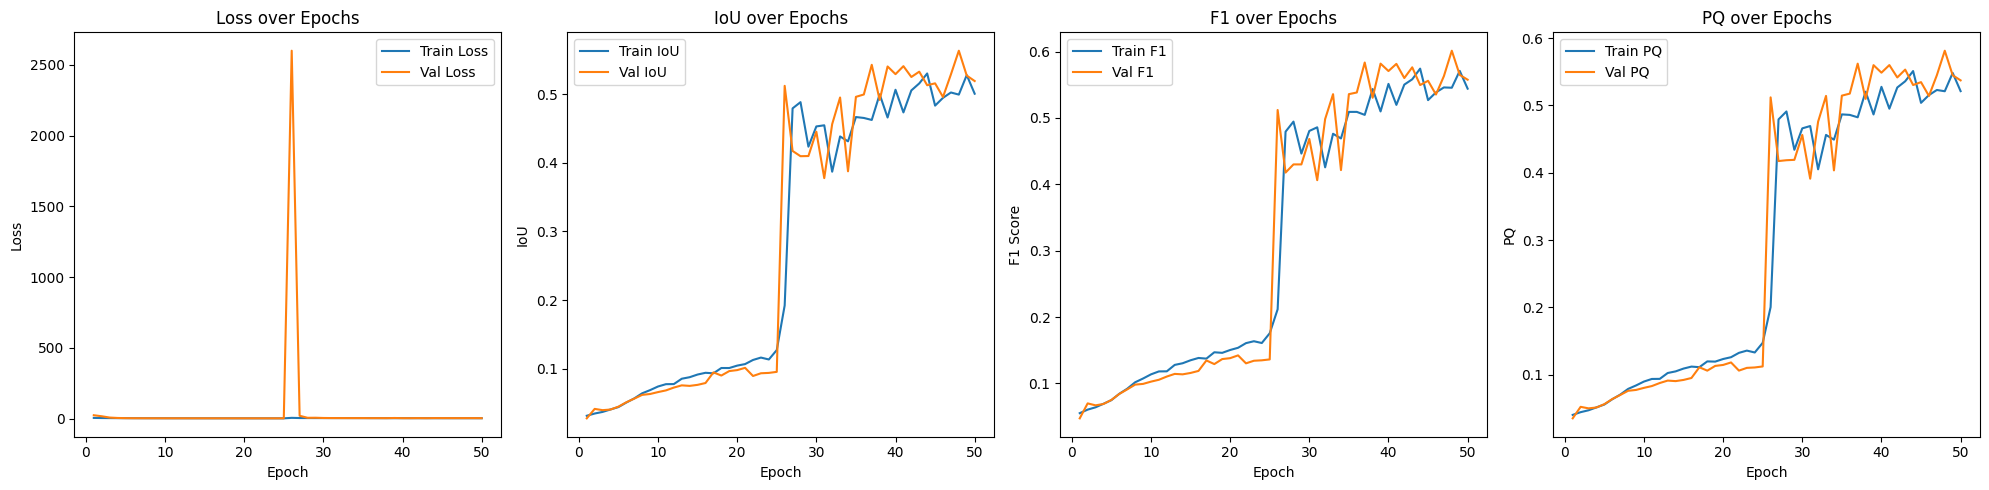

Saved training metrics to training_metrics.csv


In [73]:
train(model, criterion, train_dataloader, val_dataloader, device, 
      num_classes=NUM_CLASSES, epochs=25, patience=25)

In [74]:
final_evaluate(model, test_dataloader, criterion, device, "pretrain", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, f1=0.271, f1_per_class=[0.0729, 0.0405, 0.0469, 0.0878], iou=0.23, loss=1.37, pq=0.248] 


Final Test | Loss: 1.3711 | IoU: 0.2301 | F1: 0.2711 | PQ: 0.2482
F1 per class (excluding background): [0.917996346950531, 0.19430428743362427, 0.24041710793972015, 0.22362248599529266, 0.42602264881134033]


In [75]:
final_evaluate(model, test_dataloader, criterion, device, "finetune", num_classes=NUM_CLASSES)

Validation: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it, f1=0.641, f1_per_class=[0.1516, 0.1592, 0.1328, 0.1898], iou=0.603, loss=2.84, pq=0.621]


Final Test | Loss: 2.8350 | IoU: 0.6032 | F1: 0.6411 | PQ: 0.6215
F1 per class (excluding background): [0.9193403720855713, 0.6144382953643799, 0.519810676574707, 0.7510985732078552, 0.6791597604751587]


In [78]:
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_validation_samples(model, dataloader, device, num_classes=6, num_samples=10):
    model.eval()
    samples_shown = 0

    for image, mask, h_grads, v_grads in dataloader:
        image = image.to(device, non_blocking=True)
        mask = mask.to(device, non_blocking=True).long()
        h_grads = h_grads.to(device, non_blocking=True)
        v_grads = v_grads.to(device, non_blocking=True)
        

        np_logits, hv_logits, nc_logits, _, _ = model(image)
        np_pred = torch.argmax(np_logits, dim=1)
        nc_pred = torch.argmax(nc_logits, dim=1)

        postprocessed_pred = postprocess_hovernet_output(np_logits, hv_logits, nc_logits, device)
        
        B = image.size(0)
        for i in range(B):
            if samples_shown >= num_samples:
                return

            fig, axes = plt.subplots(1, 7, figsize=(21, 4))

            # Input image
            axes[0].imshow(image[i].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # Ground truth mask
            axes[1].imshow(mask[i].cpu().numpy(), cmap="jet")
            axes[1].set_title("Ground Truth")
            axes[1].axis('off')

            # Predicted mask
            axes[2].imshow(nc_pred[i].cpu().numpy(), cmap="jet")
            axes[2].set_title("Prediction")
            axes[2].axis('off')

            # Horizontal gradient
            axes[3].imshow(hv_logits[i, 0:1,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[3].set_title("HoVer Horizontal")
            axes[3].axis('off')

            # Vertical gradient
            axes[4].imshow(hv_logits[i, 1:2,:,:].cpu().squeeze().numpy(), cmap='viridis')
            axes[4].set_title("HoVer Vertical")
            axes[4].axis('off')

            axes[5].imshow(np_pred[i].cpu().squeeze().numpy(), cmap='gray')
            axes[5].set_title("Binary Segmentation")
            axes[5].axis('off')

            axes[6].imshow(postprocessed_pred[i].cpu().squeeze().numpy(), cmap="jet")
            axes[6].set_title("Post Processed")
            axes[6].axis('off')

            plt.tight_layout()
            plt.show()

            samples_shown += 1

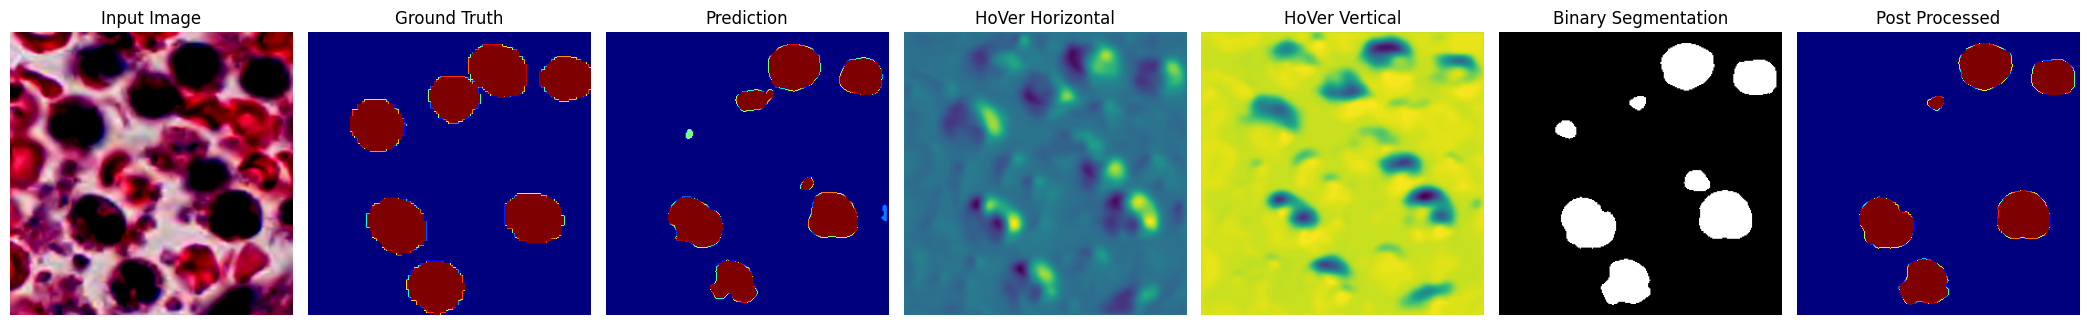

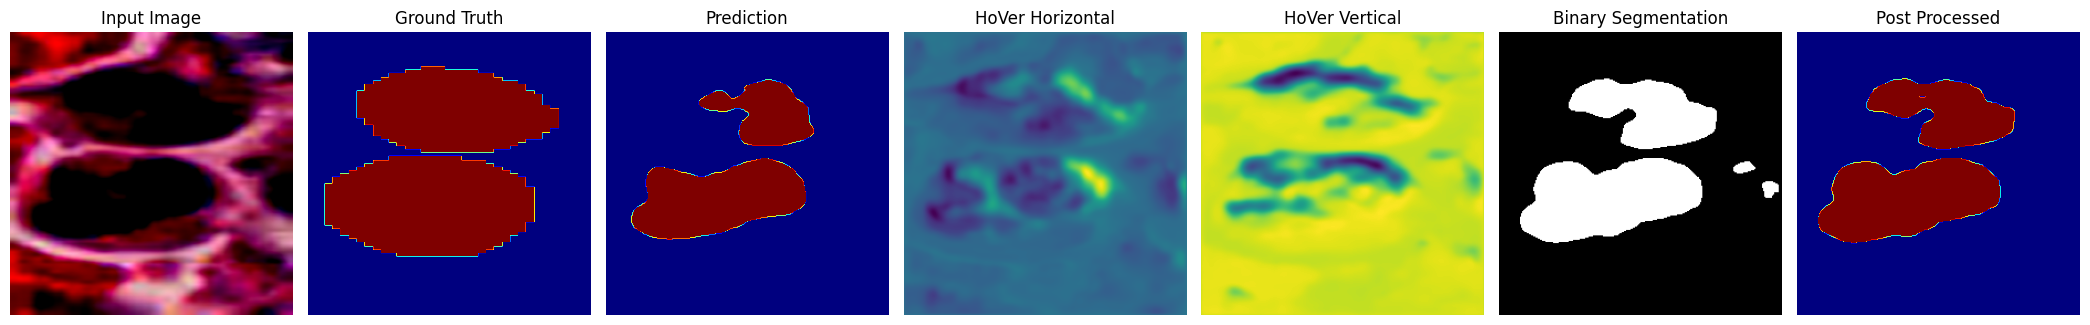

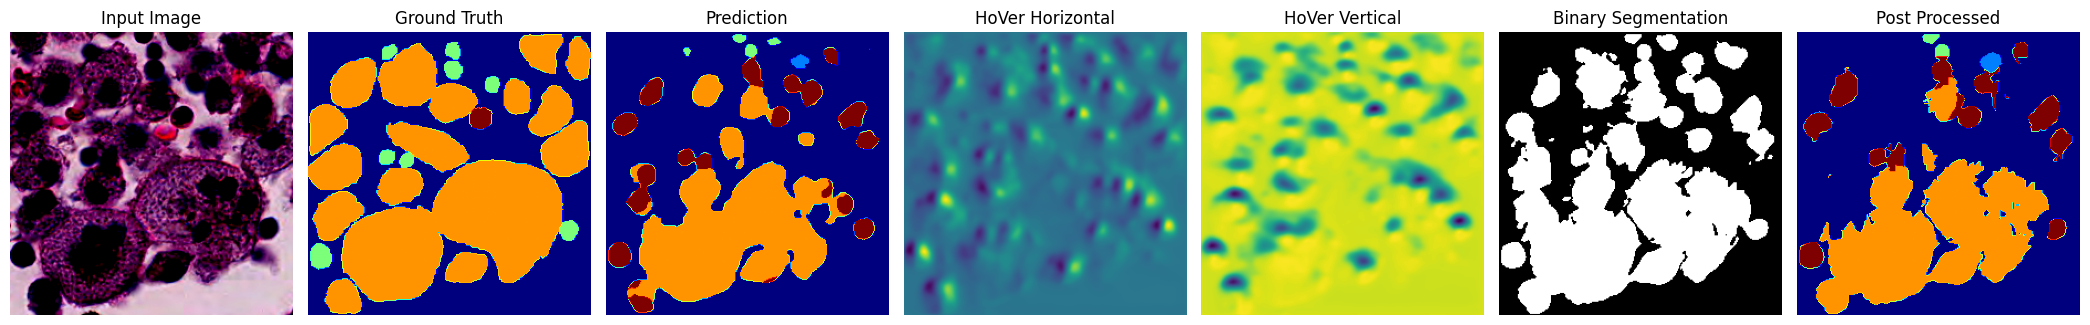

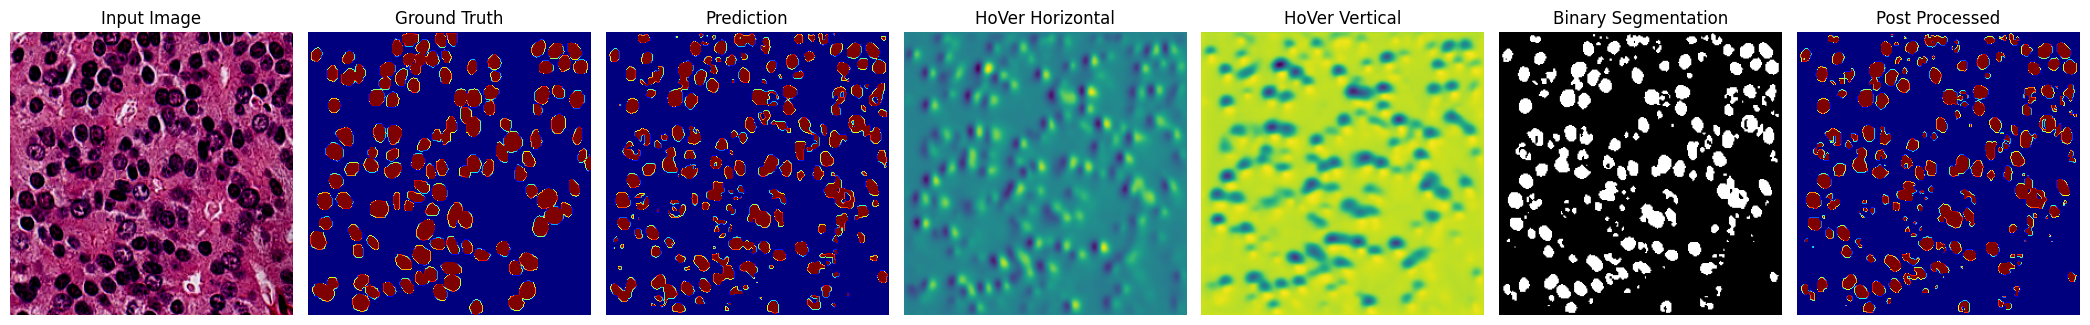

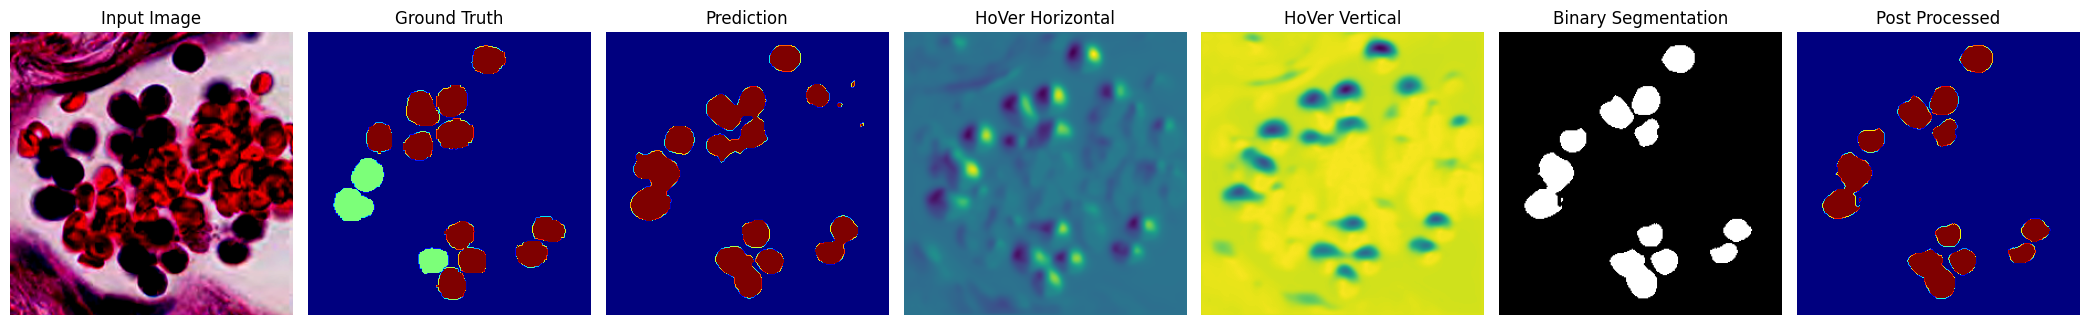

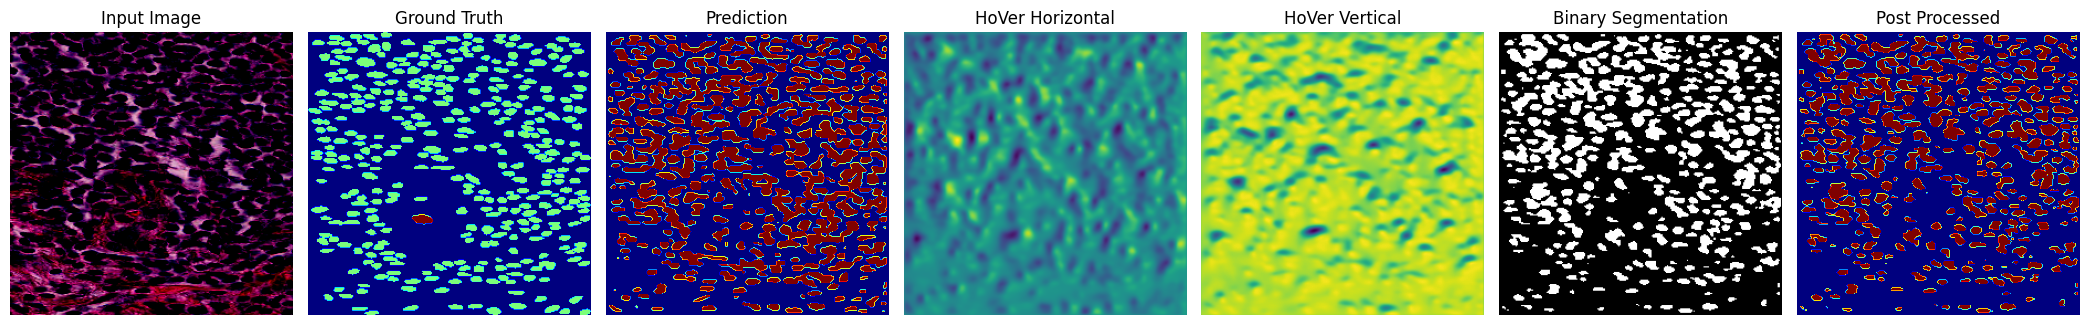

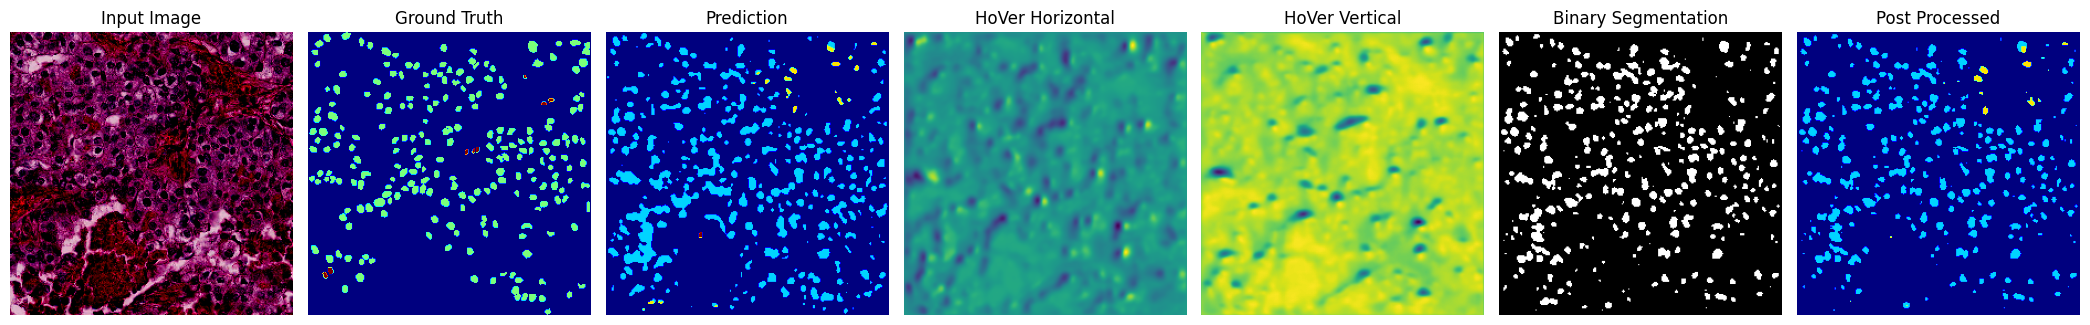

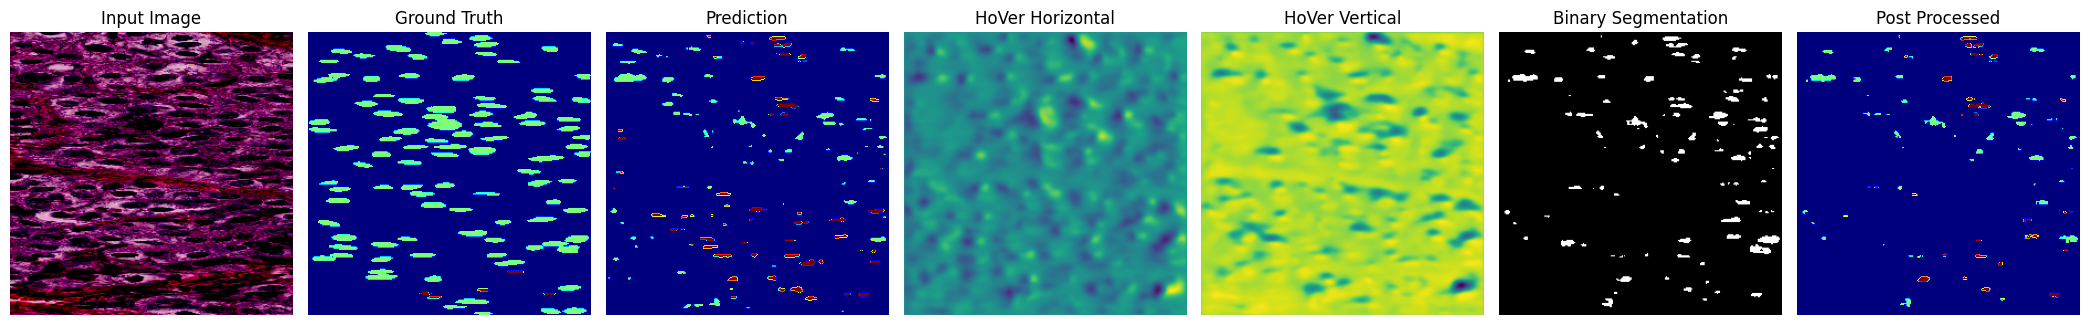

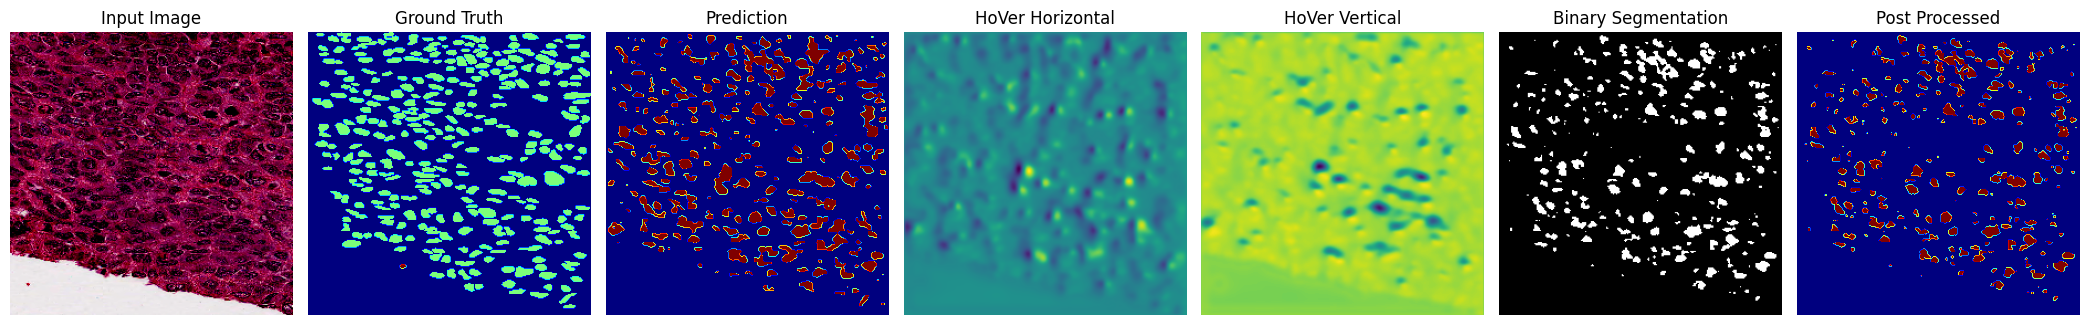

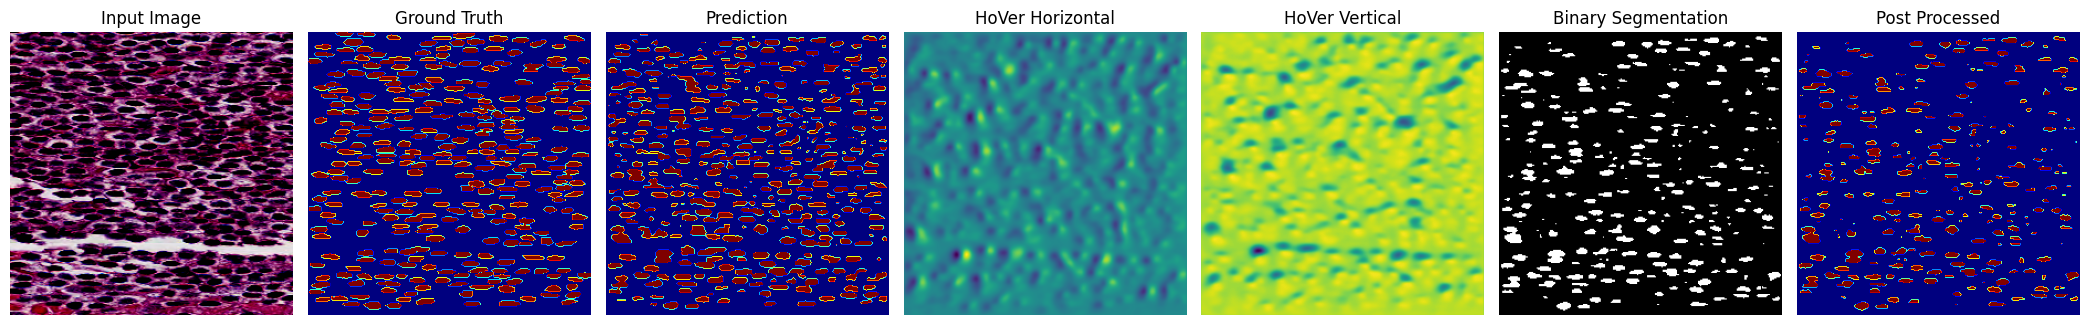

In [79]:
plot_validation_samples(model, test_dataloader, device, num_classes=NUM_CLASSES, num_samples=10)